<a href="https://colab.research.google.com/github/pietroottana/finance-portfolio/blob/main/RSI_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
TICKER = "SPY"
RSI_LENGHT = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 10000

In [43]:
def get_data():
    df = yf.download(TICKER, period = "5y")
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:, :]

In [44]:
def add_rsi(df, lenght = RSI_LENGHT):
    price_change = df["Close"].diff()

    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    avg_gain = gain.rolling(window = lenght).mean()
    avg_loss = loss.rolling(window = lenght).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df["RSI"] = rsi

    plt.plot(df["RSI"])
    plt.axhline(OVERBOUGHT, color = "red")
    plt.axhline(OVERSOLD, color = "green")

    return df.dropna()


In [45]:
def add_strategy(df, overbought = OVERBOUGHT, oversold =OVERSOLD):
    df["Strategy"] = 0
    df["Strategy"] = np.where(df["RSI"] > overbought, -1, np.where(df["RSI"] < oversold,1, 0))

    df["Strategy"] = df["Strategy"].shift(1)

    return df

/tmp/ipython-input-1882776268.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period = "5y")
[*********************100%***********************]  1 of 1 completed


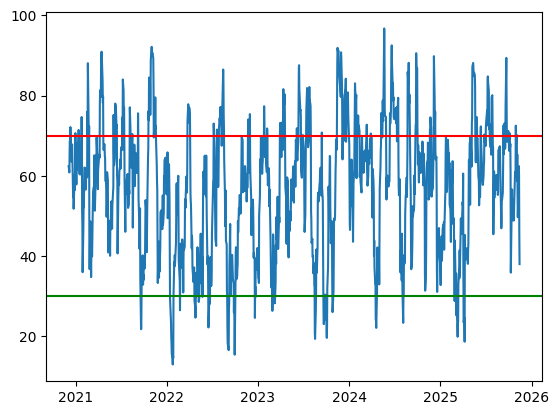

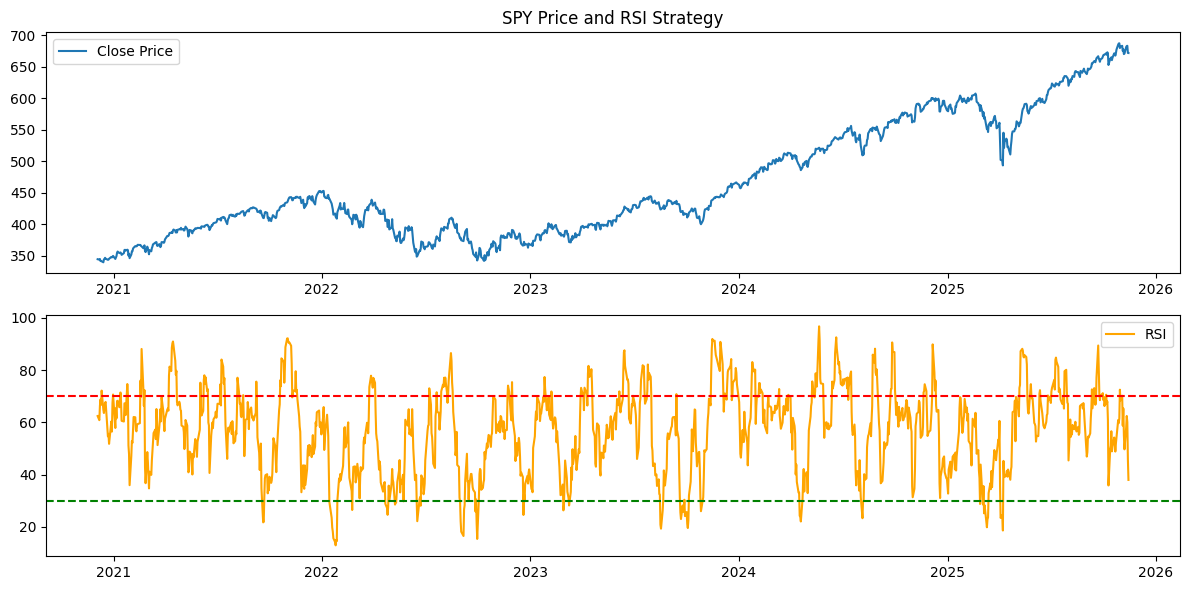

Price            Close        High         Low        Open     Volume  \
Date                                                                    
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900   
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400   
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500   
2025-11-13  672.039978  680.859985  670.520020  680.500000  103457800   
2025-11-14  671.929993  675.659973  663.270020  665.380005   96733700   

Price             RSI  Strategy  
Date                             
2025-11-10  58.056839       0.0  
2025-11-11  62.446759       0.0  
2025-11-12  60.107841       0.0  
2025-11-13  45.886617       0.0  
2025-11-14  37.998228       0.0  


In [46]:
if __name__ == "__main__":
    df = get_data()                  # Step 1: download data
    df = add_rsi(df)                 # Step 2: compute RSI
    df = add_strategy(df)            # Step 3: generate strategy signals

    # Step 4: plot everything
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.plot(df["Close"], label="Close Price")
    plt.title(f"{TICKER} Price and RSI Strategy")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(df["RSI"], label="RSI", color="orange")
    plt.axhline(OVERBOUGHT, color="red", linestyle="--")
    plt.axhline(OVERSOLD, color="green", linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Step 5: show last few rows
    print(df.tail())


/tmp/ipython-input-1882776268.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period = "5y")
[*********************100%***********************]  1 of 1 completed


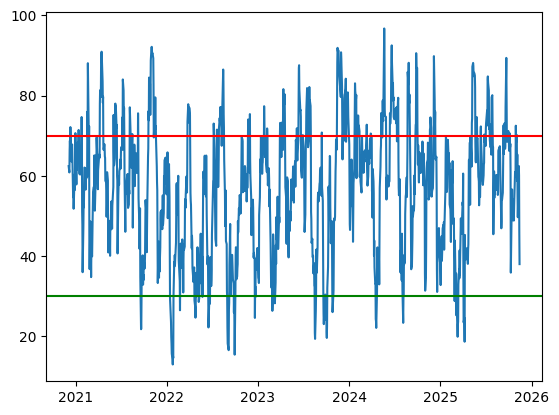

In [47]:
df = get_data()
df = add_rsi(df)
df = add_strategy(df)

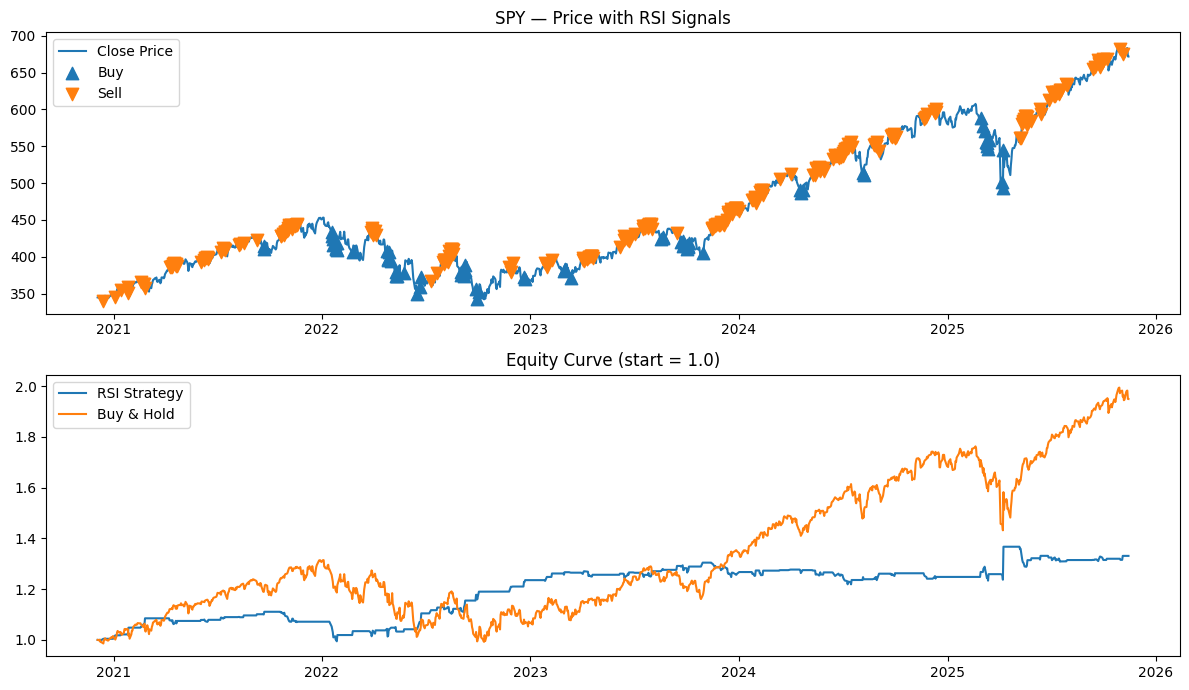

Total return — Strategy: 33.10% | Buy & Hold: 94.88%


In [48]:
# --- Backtest: equity curve (no leverage, flat when Strategy==0) ---
df["ret"] = df["Close"].pct_change().fillna(0.0)
df["str_ret"] = df["Strategy"].fillna(0.0) * df["ret"]
df["equity"] = (1 + df["str_ret"]).cumprod()

# For comparison: buy & hold, normalized to 1
df["bh"] = (1 + df["ret"]).cumprod()

# --- Plot signals on price ---
buy_idx  = df.index[df["Strategy"] == 1]
sell_idx = df.index[df["Strategy"] == -1]

plt.figure(figsize=(12,7))

# 1) Price with buy/sell markers
plt.subplot(2,1,1)
plt.plot(df.index, df["Close"], label="Close Price")
plt.scatter(buy_idx,  df.loc[buy_idx,  "Close"], marker="^", s=80, label="Buy",  zorder=3)
plt.scatter(sell_idx, df.loc[sell_idx, "Close"], marker="v", s=80, label="Sell", zorder=3)
plt.title(f"{TICKER} — Price with RSI Signals")
plt.legend()

# 2) Equity curve vs Buy & Hold
plt.subplot(2,1,2)
plt.plot(df.index, df["equity"], label="RSI Strategy")
plt.plot(df.index, df["bh"],     label="Buy & Hold")
plt.title("Equity Curve (start = 1.0)")
plt.legend()

plt.tight_layout()
plt.show()

# Quick stats
tot_str = df["equity"].iloc[-1] - 1
tot_bh  = df["bh"].iloc[-1] - 1
print(f"Total return — Strategy: {tot_str:.2%} | Buy & Hold: {tot_bh:.2%}")
